In [5]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import pandas as pd
import itertools
from CustomIndicators import moving_average, relative_strength, moving_average_convergence


In [6]:
def GetTheInputData(filename, History=False):
    # import the candle stick data
    if History == True:
        EmptyTensor = []
        MyFinalData = EmptyTensor
    else:
        MyRawData = pd.read_csv(filename) 


        #calculate time series
        MyRawData['time'] = pd.to_datetime(MyRawData['Gmt time'], format='%d.%m.%Y %H:%M:%S.000', utc=True)
        MyRawData['time'] = MyRawData['time'].dt.date
        MyRawData['time'] = pd.to_datetime(MyRawData['time'])
        MyRawData['day of week'] = MyRawData['time'].dt.dayofweek




        MyRawData['Hour'] = MyRawData['Gmt time'].str[11:13].astype(dtype=np.int64)
        MyRawData['Minute'] = MyRawData['Gmt time'].str[14:16].astype(dtype=np.int64)

        #calculate candle size parameters in pips
        MyRawData['BodyPips'] = abs((MyRawData['Open']-MyRawData['Close']) * 10000)
        MyRawData['WickUpPips'] = (abs(MyRawData['Open']-MyRawData['High']) * 10000)
        MyRawData['WickDownPips'] = (abs(MyRawData['Close']-MyRawData['Low']) * 10000)

        MyRawData['Day of Week Normal'] = (MyRawData['day of week'] /4)
        MyRawData['Hour Normal'] = (MyRawData['Hour'] /23)
        MyRawData['Minute Normal'] = (MyRawData['Minute'] /59)

        #calculate the candle type - undecision, buy , sell
        MyRawData.loc[MyRawData.BodyPips == 0, 'GreenOrRed?'] = 0
        MyRawData.loc[MyRawData.Open < MyRawData.Close, 'GreenOrRed?'] = 1
        MyRawData.loc[MyRawData.Open > MyRawData.Close, 'GreenOrRed?'] = 0



        nslow = 26
        nfast = 12
        nema = 9
        MyRawData['EmaSlow'], MyRawData['EmaFast'], MyRawData['MACD'] = moving_average_convergence(MyRawData['Close'].values, nslow=nslow, nfast=nfast)
        MyRawData['Ema9'] = moving_average(MyRawData['MACD'].values, nema, type='exponential')
        MyRawData['RSI'] = relative_strength(MyRawData['Close'].values)



        #Set number of days and standard deviations to use for rolling lookback period for Bollinger band calculation
        window = 21
        no_of_std = 2

        #Calculate rolling mean and standard deviation using number of days set above
        rolling_mean = MyRawData['Close'].rolling(window).mean()
        rolling_std = MyRawData['Close'].rolling(window).std()

        #create two new DataFrame columns to hold values of upper and lower Bollinger bands
        MyRawData['Rolling Mean'] = rolling_mean
        MyRawData['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
        MyRawData['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)

        
            #add 4 more history candle sticks
        for CandleCount in range(10):
            ActualCandleCount = CandleCount + 1
            MyRawData['BodyPips' + '_' + str(ActualCandleCount)] = MyRawData['BodyPips'].shift(-ActualCandleCount)
            MyRawData['WickUpPips' + '_' + str(ActualCandleCount)] = MyRawData['WickUpPips'].shift(-ActualCandleCount)
            MyRawData['WickDownPips' + '_' + str(ActualCandleCount)] = MyRawData['WickDownPips'].shift(-ActualCandleCount)
            MyRawData['Day of Week Normal' + '_' + str(ActualCandleCount)] = MyRawData['Minute Normal'].shift(-ActualCandleCount)
            MyRawData['Hour Normal' + '_' + str(ActualCandleCount)] = MyRawData['Hour Normal'].shift(-ActualCandleCount)
            MyRawData['Minute Normal' + '_' + str(ActualCandleCount)] = MyRawData['Minute Normal'].shift(-ActualCandleCount)
            MyRawData['GreenOrRed?' + '_' + str(ActualCandleCount)] = MyRawData['GreenOrRed?'].shift(-ActualCandleCount)
            MyRawData['EmaSlow' + '_' + str(ActualCandleCount)] = MyRawData['EmaSlow'].shift(-ActualCandleCount)
            MyRawData['EmaFast' + '_' + str(ActualCandleCount)] = MyRawData['EmaFast'].shift(-ActualCandleCount)
            MyRawData['MACD' + '_' + str(ActualCandleCount)] = MyRawData['MACD'].shift(-ActualCandleCount)
            MyRawData['Ema9' + '_' + str(ActualCandleCount)] = MyRawData['Ema9'].shift(-ActualCandleCount)
            MyRawData['RSI' + '_' + str(ActualCandleCount)] = MyRawData['RSI'].shift(-ActualCandleCount)
            MyRawData['Rolling Mean' + '_' + str(ActualCandleCount)] = MyRawData['Rolling Mean'].shift(-ActualCandleCount)
            MyRawData['Bollinger High' + '_' + str(ActualCandleCount)] = MyRawData['Bollinger High'].shift(-ActualCandleCount)
            MyRawData['Bollinger Low' + '_' + str(ActualCandleCount)] = MyRawData['Bollinger Low'].shift(-ActualCandleCount)


        
        #populate las column with the output
        MyRawData['Close_ver1'] = MyRawData['Close'].shift(10)
        MyRawData['Close_ver2'] = MyRawData['Close'].shift(15)
        MyRawData.loc[MyRawData.Close_ver1 < MyRawData.Close_ver2, 'output'] = 1
        MyRawData.loc[MyRawData.Close_ver1 >= MyRawData.Close_ver2, 'output'] = 0




            #remove not important fields
        del MyRawData['Close_ver1']
        del MyRawData['Close_ver2']
        del MyRawData['Gmt time']
        del MyRawData['Open']
        del MyRawData['High']
        del MyRawData['Low']
        del MyRawData['Close']
        del MyRawData['Volume']
        del MyRawData['time']
        del MyRawData['day of week']
        del MyRawData['Hour'] 
        del MyRawData['Minute'] 

        #remove last row without output value
        MyFinalData = MyRawData[50:-50]

        #export_csv = MyRawData.to_csv ('test.csv', index = None, header=True)

    
    return MyFinalData

In [74]:
df = GetTheInputData('filename.csv')

In [90]:
dataset = df.values

In [91]:
len(dataset)

871100

In [92]:
X = dataset[:, 0:165]
Y = dataset[:, 165]

In [93]:
Y

array([1., 1., 1., ..., 1., 0., 1.])

In [ ]:


#**************************************


#********** Normalize the Input Values ************
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)
#**************************************************


#********** Cut Values to 3 piecies ************
#Normalized
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
#Raw
X_train_Raw, X_val_and_test_Raw, Y_train_Raw, Y_val_and_test_Raw = train_test_split(X, Y, test_size=0.3)
X_val_Raw, X_test_Raw, Y_val_Raw, Y_test_Raw = train_test_split(X_val_and_test_Raw, Y_val_and_test_Raw, test_size=0.5)
#print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
#***********************************************



In [ ]:


#********** Build the Model and Compile ************
model = Sequential()
model.add(Dense(128, input_dim=165, kernel_initializer='normal', activation='relu'))
model.add(Dense(32, kernel_initializer='normal', activation='relu'))
model.add(Dense(16, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#***************************************************


#********** Train the Model ********************
hist = model.fit(X_train, Y_train,batch_size=2048, epochs=12,validation_data=(X_val, Y_val))
#***********************************************


#********** Test the Model on New Data ********************
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)
#*********************************************************


#********** Perform predictions on new Dataset ********************
predictions = model.predict(X_test)
#******************************************************************



In [81]:


#********** Calculate the Stats ********************
# 1.Define stats variables
TotalTrades = 0
GoodTrades = 0
counter = 0
WeekDayStats = {'Monday':[0,0],'Tuesday':[0,0],'Wendsday':[0,0],'Thursday':[0,0],'Friday':[0,0]}
ConsequtiveStats = []

PredictedResults = []

LastWon = False
Weekdays = round(len(predictions)/7200,0)


# 2.Loop through predictions
for prediction_check in predictions:
    if prediction_check > 0.99999 or prediction_check < 0.00001:
        # Predictions above threshold

        TotalTrades = TotalTrades+1
        Map_Raw_Data = X_test_Raw[counter]
        
     
        
        # Check if won or lost
        WonLost_WeekDay_Coutner = 0
        if np.argmax(predictions[counter]) == Y_test[counter]:
            # Won
            GoodTrades = GoodTrades + 1
            WonLost_WeekDay_Coutner = 0
            ConsequtiveStats.append(1)
            
        else:
            WonLost_WeekDay_Coutner = 1
            ConsequtiveStats.append(0)
            
            
        if Map_Raw_Data[3] == 0: WeekDayStats['Monday'][WonLost_WeekDay_Coutner] = WeekDayStats['Monday'][WonLost_WeekDay_Coutner] + 1
        if Map_Raw_Data[3] == 0.25: WeekDayStats['Tuesday'][WonLost_WeekDay_Coutner] = WeekDayStats['Tuesday'][WonLost_WeekDay_Coutner] + 1
        if Map_Raw_Data[3] == 0.5: WeekDayStats['Wendsday'][WonLost_WeekDay_Coutner] = WeekDayStats['Wendsday'][WonLost_WeekDay_Coutner] + 1
        if Map_Raw_Data[3] == 0.75: WeekDayStats['Thursday'][WonLost_WeekDay_Coutner] = WeekDayStats['Thursday'][WonLost_WeekDay_Coutner] + 1
        if Map_Raw_Data[3] == 1: WeekDayStats['Friday'][WonLost_WeekDay_Coutner] = WeekDayStats['Friday'][WonLost_WeekDay_Coutner] + 1
        
            
            
            
    counter = counter + 1

# 3. Append stats variables

z = [(x[0], len(list(x[1]))) for x in itertools.groupby(ConsequtiveStats)]    

MaxLost = 0
MaxWon = 0

for a in z:
    if a[0]==0:
        if a[1] > MaxLost: MaxLost = a[1]
    else:
        if a[1] > MaxWon: MaxWon = a[1]



#Get average trades per week
for key, value in WeekDayStats.items():
    value[0] = round(value[0]/Weekdays,0)
    value[1] = round(value[1]/Weekdays,0)

print ('Trades: ' + str(TotalTrades) + ' -- ' + 'Good trades: ' + str(GoodTrades) + ' -- ' + 'Percantage: ' + str(round(((GoodTrades/TotalTrades)*100),2))+ '%')


#******************************************************************





Trades: 8 -- Good trades: 6 -- Percantage: 75.0%


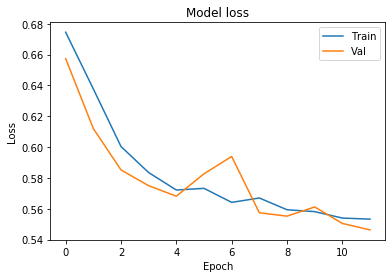

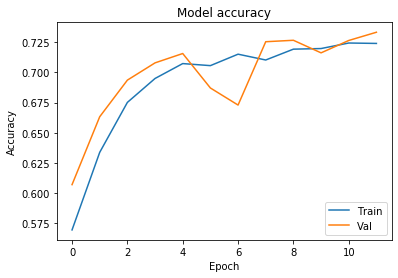

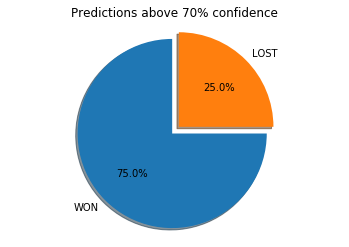

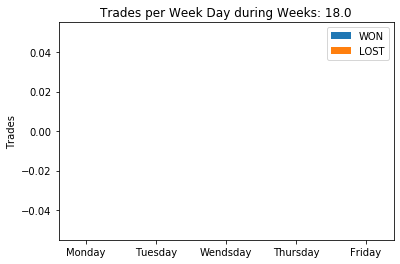

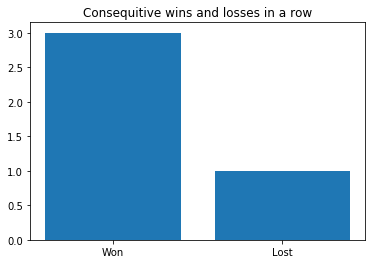

In [82]:



#********** Create the Charts Dashboard ********************

# Chart 1 - Model Loss
#plt.subplot(331)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


# Chart 2 - Model Accuracy
#plt.subplot(332)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()


# Chart 3 - Lost and Won trades % above 70%
#plt.subplot(333)
labels = 'WON', 'LOST'
sizes = [GoodTrades, (TotalTrades-GoodTrades)]
explode = (0, 0.1)  
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Predictions above 70% confidence')
plt.show()


# Chart 4 - Average Trades per week day

#plt.subplot(334)
N = 5
TradesWonWeekDay = (WeekDayStats['Monday'][0]+WeekDayStats['Monday'][1], 
                    WeekDayStats['Tuesday'][0]+WeekDayStats['Tuesday'][1],
                    WeekDayStats['Wendsday'][0]+WeekDayStats['Wendsday'][1], 
                    WeekDayStats['Thursday'][0]+WeekDayStats['Thursday'][1], 
                    WeekDayStats['Friday'][0]+WeekDayStats['Friday'][1])
TradesLostWeekDay = (WeekDayStats['Monday'][1], WeekDayStats['Tuesday'][1], WeekDayStats['Wendsday'][1], WeekDayStats['Thursday'][1], WeekDayStats['Friday'][1])



ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, TradesWonWeekDay, width)
p2 = plt.bar(ind, TradesLostWeekDay, width)

plt.ylabel('Trades')
plt.title('Trades per Week Day during Weeks: ' + str(Weekdays))
plt.xticks(ind, ('Monday', 'Tuesday', 'Wendsday', 'Thursday', 'Friday'))
plt.legend((p1[0], p2[0]), ('WON', 'LOST'))
plt.show()


# Chart 5 - Consequtive Losses and Wins
#plt.subplot(335)
plt.title('Consequitive wins and losses in a row')
x = np.arange(2)
money = [MaxWon,MaxLost]
plt.bar(x, money)
plt.xticks(x, ('Won','Lost'))


#**************************************
plt.show()
#******************************************************************


In [83]:
#***** Get the Values from Pandas *****
dff = GetTheInputData('EURUSD_M1_NEW.csv')
datasett = dff.values
XX = datasett[:, 0:165]
YY = datasett[:, 165]
#**************************************

In [84]:
#********** Normalize the Input Values ************
min_max_scaler = preprocessing.MinMaxScaler()
XX_scale = min_max_scaler.fit_transform(XX)
#**************************************************

In [85]:

#********** Test the Model on New Data ********************
test_loss, test_acc = model.evaluate(XX, YY)
print('Test accuracy:', test_acc)
#*********************************************************

#********** Perform predictions on new Dataset ********************
predictions = model.predict(XX_scale)
#******************************************************************



44345/44345 [==============================] - 1s 31us/step
Test accuracy: 0.4720036080710473


In [88]:

#********** Calculate the Stats ********************
# 1.Define stats variables
TotalTrades = 0
GoodTrades = 0
counter = 0
WeekDayStats = {'Monday':[0,0],'Tuesday':[0,0],'Wendsday':[0,0],'Thursday':[0,0],'Friday':[0,0]}
ConsequtiveStats = []

PredictedResults = []

LastWon = False
Weekdays = round(len(predictions)/7200,0)


# 2.Loop through predictions
for prediction_check in predictions:
    if prediction_check > 0.999999999 or prediction_check < 0.000000001:
        # Predictions above threshold

        TotalTrades = TotalTrades+1
        Map_Raw_Data = XX[counter]
        
     
     
        # Check if won or lost
        WonLost_WeekDay_Coutner = 0
        if np.argmax(predictions[counter]) == YY[counter]:
            # Won
            GoodTrades = GoodTrades + 1
            WonLost_WeekDay_Coutner = 0
            ConsequtiveStats.append(1)
            
        else:
            WonLost_WeekDay_Coutner = 1
            ConsequtiveStats.append(0)
            
            
        if Map_Raw_Data[3] == 0: WeekDayStats['Monday'][WonLost_WeekDay_Coutner] = WeekDayStats['Monday'][WonLost_WeekDay_Coutner] + 1
        if Map_Raw_Data[3] == 0.25: WeekDayStats['Tuesday'][WonLost_WeekDay_Coutner] = WeekDayStats['Tuesday'][WonLost_WeekDay_Coutner] + 1
        if Map_Raw_Data[3] == 0.5: WeekDayStats['Wendsday'][WonLost_WeekDay_Coutner] = WeekDayStats['Wendsday'][WonLost_WeekDay_Coutner] + 1
        if Map_Raw_Data[3] == 0.75: WeekDayStats['Thursday'][WonLost_WeekDay_Coutner] = WeekDayStats['Thursday'][WonLost_WeekDay_Coutner] + 1
        if Map_Raw_Data[3] == 1: WeekDayStats['Friday'][WonLost_WeekDay_Coutner] = WeekDayStats['Friday'][WonLost_WeekDay_Coutner] + 1
        
         
            
            
    counter = counter + 1

# 3. Append stats variables

z = [(x[0], len(list(x[1]))) for x in itertools.groupby(ConsequtiveStats)]    

MaxLost = 0
MaxWon = 0

for a in z:
    if a[0]==0:
        if a[1] > MaxLost: MaxLost = a[1]
    else:
        if a[1] > MaxWon: MaxWon = a[1]



#Get average trades per week
for key, value in WeekDayStats.items():
    value[0] = round(value[0]/Weekdays,0)
    value[1] = round(value[1]/Weekdays,0)

print ('Trades: ' + str(TotalTrades) + ' -- ' + 'Good trades: ' + str(GoodTrades) + ' -- ' + 'Percantage: ' + str(round(((GoodTrades/TotalTrades)*100),2))+ '%')


#******************************************************************


Trades: 172 -- Good trades: 154 -- Percantage: 89.53%


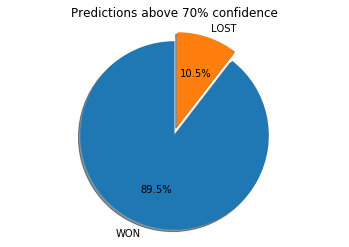

(2.0, 2.0, 8.0, 10.0, 6.0)
(0.0, 0.0, 1.0, 1.0, 1.0)


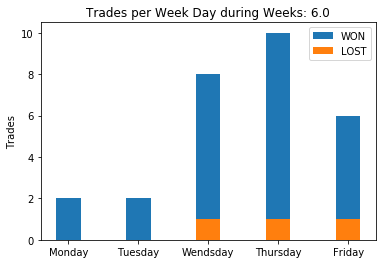

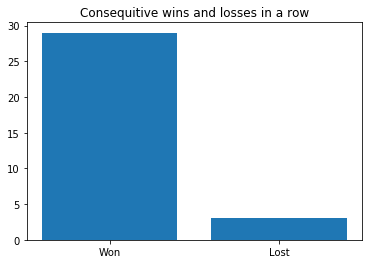

In [89]:

#********** Create the Charts Dashboard ********************


# Chart 3 - Lost and Won trades % above 70%
#plt.subplot(333)
labels = 'WON', 'LOST'
sizes = [GoodTrades, (TotalTrades-GoodTrades)]
explode = (0, 0.1)  
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Predictions above 70% confidence')
plt.show()


# Chart 4 - Average Trades per week day

#plt.subplot(334)
N = 5
TradesWonWeekDay = (WeekDayStats['Monday'][0]+WeekDayStats['Monday'][1], 
                    WeekDayStats['Tuesday'][0]+WeekDayStats['Tuesday'][1],
                    WeekDayStats['Wendsday'][0]+WeekDayStats['Wendsday'][1], 
                    WeekDayStats['Thursday'][0]+WeekDayStats['Thursday'][1], 
                    WeekDayStats['Friday'][0]+WeekDayStats['Friday'][1])
TradesLostWeekDay = (WeekDayStats['Monday'][1], WeekDayStats['Tuesday'][1], WeekDayStats['Wendsday'][1], WeekDayStats['Thursday'][1], WeekDayStats['Friday'][1])
print(TradesWonWeekDay)
print(TradesLostWeekDay)

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, TradesWonWeekDay, width)
p2 = plt.bar(ind, TradesLostWeekDay, width)

plt.ylabel('Trades')
plt.title('Trades per Week Day during Weeks: ' + str(Weekdays))
plt.xticks(ind, ('Monday', 'Tuesday', 'Wendsday', 'Thursday', 'Friday'))
plt.legend((p1[0], p2[0]), ('WON', 'LOST'))
plt.show()


# Chart 5 - Consequtive Losses and Wins
#plt.subplot(335)
plt.title('Consequitive wins and losses in a row')
x = np.arange(2)
money = [MaxWon,MaxLost]
plt.bar(x, money)
plt.xticks(x, ('Won','Lost'))


#**************************************
plt.show()
#******************************************************************
